In [265]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sp
from scipy.stats import norm
from scipy.stats import gamma
%matplotlib inline

In [266]:
df = pd.read_csv('./../data/clean_data.csv')

In [267]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [268]:
df['type'].value_counts()

tx         973640
call       492595
create      27726
suicide       318
Name: type, dtype: int64

In [269]:
df['newContract'].value_counts()

0    1489351
1       4928
Name: newContract, dtype: int64

In [270]:
for col in df.columns:
    print(col, df[col].isnull().sum())

_id_t 0
accountNonce 0
amount 0
blockHash 0
block_id 0
gasLimit_t 0
gasUsed_t 0
hash_t 0
newContract 0
parentHash_t 0
price 0
recipient 0
sender 0
time_t 0
type 0
_id_b 0
blockTime 0
coinbase 0
difficulty 0
extra 0
gasLimit_b 0
gasUsed_b 0
hash_b 0
mixDigest 1494279
nonce 0
number 0
parentHash_b 0
reward 0
root 0
size 0
time_b 0
totalFee 0
txHash 0
tx_count 0
uncleHash 0
uncle_count 0
price_gwei 0
amount_gwei 0
gasShare 0
gweiPaid 0
gweiPaid_b 0
gweiShare 2
free_t 0
day 0
hour 0
dayofweek 0


In [271]:
df.drop('mixDigest', axis=1, inplace=True)

In [272]:
df.dropna(inplace=True)

## Generate new columns

In [273]:
df['txcnt_second'] = df['tx_count'].values / df['blockTime'].values
df['avg_gasUsed_t_perblock'] = df.groupby('block_id')['gasUsed_t'].transform('mean')
df['avg_price_perblock'] = df.groupby('block_id')['price_gwei'].transform('mean')

In [274]:
def rolling_avg(window_size):
    
    price = df[['block_id', 'avg_price_perblock']].drop_duplicates().sort_values(
                        'block_id', ascending=True)
    
    gasUsed_t = df[['block_id', 'avg_gasUsed_t_perblock']].drop_duplicates().sort_values(
                            'block_id', ascending=True)
    
    txcnt_second = df[['block_id', 'txcnt_second']].drop_duplicates().sort_values(
                                'block_id', ascending=True)
    
    tx_count = df[['block_id', 'tx_count']].drop_duplicates().sort_values(
                            'block_id', ascending=True)
    
    gasUsed_b = df[['block_id', 'gasUsed_b']].drop_duplicates().sort_values(
                            'block_id', ascending=True)
    
    uncle_count = df[['block_id', 'uncle_count']].drop_duplicates().sort_values(
                                'block_id', ascending=True)
    
    difficulty = df[['block_id', 'difficulty']].drop_duplicates().sort_values(
                                'block_id', ascending=True)
    
    blocktime = df[['block_id', 'blockTime']].drop_duplicates().sort_values(
                             'block_id', ascending=True)
    
    # create new pandas dataframe with average values
    rolling_avg = pd.DataFrame()
    
    # calculate rolling averages 
    rolling_avg['avg_blocktime'] = blocktime['blockTime'].rolling(window=window_size).mean()
    rolling_avg['avg_gasUsed_b'] = gasUsed_b['gasUsed_b'].rolling(window=window_size).mean()
    rolling_avg['avg_tx_count'] = tx_count['tx_count'].rolling(window=window_size).mean()
    rolling_avg['avg_uncle_count'] = uncle_count['uncle_count'].rolling(window=window_size).mean()
    rolling_avg['avg_difficulty'] = difficulty['difficulty'].rolling(window=window_size).mean()
    rolling_avg['avg_txcnt_second'] = txcnt_second['txcnt_second'].rolling(window=window_size).mean()
    rolling_avg['avg_gasUsed_t'] = gasUsed_t['avg_gasUsed_t_perblock'].rolling(window=window_size).mean()
    rolling_avg['avg_price'] = price['avg_price_perblock'].rolling(window=window_size).mean()
    
    # insert blockids to merge on
    rolling_avg['blockids'] = df['block_id'].drop_duplicates().sort_values(ascending=True)
    
    return rolling_avg

## Take average values over two time horizons
- 6 blocks (~1 min) -> represents the current state (short frequency view)
- 60 blocks (~10 min) -> represents the long term view

In [275]:
num_blocks = [6, 60]
for num in num_blocks:
    df_rolling_avg = rolling_avg(num)
    df_rolling_avg.to_csv('./../data/block_avg_{}.csv'.format(num))

In [276]:
df_rolling_avg_6 = rolling_avg(6)

In [277]:
df_rolling_avg_60 = rolling_avg(60)

## Merge data with new columns

In [278]:
merged1 = pd.merge(df, df_rolling_avg_6, left_on='block_id', right_on='blockids')

In [279]:
merged2 = pd.merge(merged1, df_rolling_avg_60, left_on='block_id', right_on='blockids', suffixes=('_6', '_60'))

In [280]:
merged2.columns

Index([u'_id_t', u'accountNonce', u'amount', u'blockHash', u'block_id',
       u'gasLimit_t', u'gasUsed_t', u'hash_t', u'newContract', u'parentHash_t',
       u'price', u'recipient', u'sender', u'time_t', u'type', u'_id_b',
       u'blockTime', u'coinbase', u'difficulty', u'extra', u'gasLimit_b',
       u'gasUsed_b', u'hash_b', u'nonce', u'number', u'parentHash_b',
       u'reward', u'root', u'size', u'time_b', u'totalFee', u'txHash',
       u'tx_count', u'uncleHash', u'uncle_count', u'price_gwei',
       u'amount_gwei', u'gasShare', u'gweiPaid', u'gweiPaid_b', u'gweiShare',
       u'free_t', u'day', u'hour', u'dayofweek', u'txcnt_second',
       u'avg_gasUsed_t_perblock', u'avg_price_perblock', u'avg_blocktime_6',
       u'avg_gasUsed_b_6', u'avg_tx_count_6', u'avg_uncle_count_6',
       u'avg_difficulty_6', u'avg_txcnt_second_6', u'avg_gasUsed_t_6',
       u'avg_price_6', u'blockids_6', u'avg_blocktime_60', u'avg_gasUsed_b_60',
       u'avg_tx_count_60', u'avg_uncle_count_60', u'avg_

# Create a label
- What are we predicting? 
- A hindsight estimate of what the price should be, given knowledge about previous blocks
- Develop a summary statistic about the distribution of prices over previous blocks
- Our target: the 25th percentile of the distribution (gweiShare / gasShare)

## Definitions
- gasUsed_t -> the amount of gas consumed on a transation
- gasUsed_b -> the amount of gas consumed in an entire block
- price_gwei -> the price per unit gas 
- gweiPaid -> the total amount paid (Gwei) for a transaction (= gasUsed_t x price_gwei)
- gweiPaid_b -> the total amount paid in a block 
- gweiShare -> the fraction of gwei paid w.r.t. the entire block
- gasShare -> the fraction of gas consumed w.r.t. the entire block

## Define "miner value" – mu
- a measure of how likely a transaction is to be "picked up" by a miner for completion (risk factor)
- mu = c x gweiShare / gasShare
- our target/goal is for mu to be the 25th percentile of gweiShare / gasShare
- c can serve as a tuning parameter to increase or decrease our desired percentile 
- it is a pre-emptive statistical calculation based on our hindsight knowledge

## The "price" predicted with hindsight 
- knowing mu, how do we obtain our hindsight recommendation?
- using our definition of mu, we solve equation to obtain p (price)
- p = (mu x gweiPaid_b) / gasUsed_b
- this will serve as our label and thus recommendation for how much to pay per unit gas for a transation to successfully commence 

## Calculate mu for our dataset
- given a distribution of mu for a given block, fit a statistical model to the data
- use this fit model to compute the 25th percentile of the distribution

In [281]:
merged2['gweiShare'].head()

0    0.051115
1    0.022919
2    0.051115
3    0.051115
4    0.051115
Name: gweiShare, dtype: float64

In [282]:
merged2['gasShare'].head(10)

0    0.054830
1    0.024585
2    0.054830
3    0.054830
4    0.054830
5    0.103163
6    0.080889
7    0.054830
8    0.000000
9    0.103163
Name: gasShare, dtype: float64

In [283]:
merged2[['block_id','price_gwei','gasUsed_t', 'gasUsed_b', 'gweiShare', 'gasShare']].head(10)

,block_id,price_gwei,gasUsed_t,gasUsed_b,gweiShare,gasShare
0,4295887,21.0,21000,383005,0.051115,0.054830
1,4295887,21.0,9416,383005,0.022919,0.024585
2,4295887,21.0,21000,383005,0.051115,0.054830
3,4295887,21.0,21000,383005,0.051115,0.054830
4,4295887,21.0,21000,383005,0.051115,0.054830
5,4295887,21.0,39512,383005,0.096174,0.103163
6,4295887,21.0,30981,383005,0.075409,0.080889
7,4295887,21.0,21000,383005,0.051115,0.054830
8,4295887,21.0,0,383005,0.000000,0.000000
9,4295887,21.0,39512,383005,0.096174,0.103163


In [284]:
merged2['mu'] = merged2.gweiShare / merged2.gasShare

In [285]:
merged2['mu'].fillna(value=0, inplace=True)

In [286]:
merged2['mu'].isnull().sum()

0

In [287]:
merged2['mu'].describe()

count    1.494277e+06
mean     1.533342e+00
std      4.397501e+00
min      0.000000e+00
25%      6.311163e-01
50%      1.114737e+00
75%      1.842494e+00
max      4.233297e+03
Name: mu, dtype: float64

In [288]:
merged2.groupby('block_id')['mu'].count().head()

block_id
4286251    262
4286252    247
4286253    209
4286254    111
4286255    200
Name: mu, dtype: int64

In [289]:
merged2.groupby('block_id')['mu'].count().mean()

102.47407762995473

There are only on average 102 samples in each block

In [290]:
merged2.groupby('block_id')['mu'].count().max()

558

### Fit statistical model for one case

In [307]:
merged2[merged2['block_id'] == 4286252]['mu'].describe()

count    247.000000
mean       1.069806
std        0.371786
min        0.000000
25%        0.890820
50%        0.890820
75%        1.503928
max        3.007856
Name: mu, dtype: float64

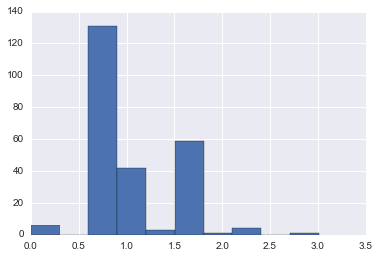

In [308]:
merged2[merged2['block_id'] == 4286252]['mu'].hist()

In [309]:
samples = merged2[merged2['block_id'] == 4286252]['mu']

In [310]:
# compute mean, variance, standard deviation
mu_hat = np.mean(samples)
sigma_sq_hat = np.var(samples)
sigma_hat = np.std(samples)
print("Sample Mean: {0:1.3f}".format(mu_hat))
print("Sample Variance: {0:1.3f}".format(sigma_sq_hat))
print("Sample Standard Dev: {0:1.3f}".format(sigma_hat))

Sample Mean: 1.070
Sample Variance: 0.138
Sample Standard Dev: 0.371


(0, 2)

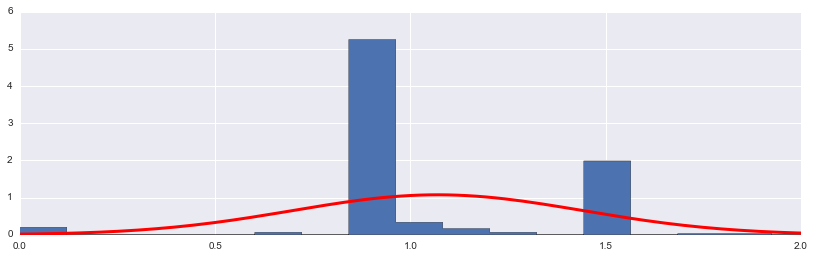

In [311]:
x = np.linspace(-3, 3, num=250)
fig, ax = plt.subplots(1, 1, figsize=(14, 4))

ax.hist(samples, bins=25, normed=True, histtype='stepfilled')
ax.plot(x, norm.pdf(x, mu_hat,sigma_hat), 'r-', lw=3, label='Normal MOM')
ax.set_xlim(0,2)

In [312]:
# compute 25th percentile
np.percentile(sp.norm.pdf(x, mu_hat, sigma_sq_hat), 25.0)

1.9993176879516347e-75

### Use bootstrap sampling to increase number of samples

In [313]:
# take bootstrap samples with replacement
def bootstraper(a, num):
    
    arr_flat = a.flatten()
    boot_a = np.random.choice(arr_flat, num, replace=True)

    return boot_a

In [314]:
boot_samples = bootstraper(samples.values, 100000)

In [315]:
# compute mean, variance, standard deviation
mu_hat_b = np.mean(boot_samples)
sigma_sq_hat_b = np.var(boot_samples)
sigma_hat_b = np.std(boot_samples)
print("Bootstrapped Sample Mean: {0:1.3f}".format(mu_hat_b))
print("Bootstrapped Sample Variance: {0:1.3f}".format(sigma_sq_hat_b))
print("Bootstrapped Sample Standard Dev: {0:1.3f}".format(sigma_hat_b))

Bootstrapped Sample Mean: 1.070
Bootstrapped Sample Variance: 0.138
Bootstrapped Sample Standard Dev: 0.372


In [316]:
boot_samples.shape

(100000,)

(0, 2)

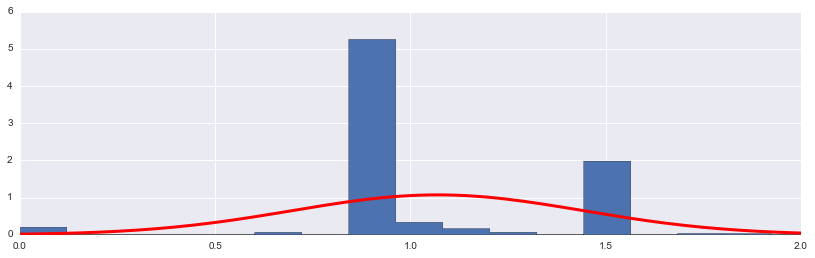

In [317]:
x = np.linspace(-3, 3, num=250)
fig, ax = plt.subplots(1, 1, figsize=(14, 4))

ax.hist(boot_samples, bins=25, normed=True, histtype='stepfilled')
ax.plot(x, norm.pdf(x, mu_hat_b,sigma_hat_b), 'r-', lw=3, label='Normal MOM')
ax.set_xlim(0,2)

In [318]:
# compute 25th percentile
np.percentile(sp.norm.pdf(x, mu_hat_b, sigma_sq_hat_b), 25.0)

6.3268072199996653e-75

The value for mu is very small